In [ ]:
import cv2
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def convert_to_grayscale(path):

    image = np.float32(cv2.imread(path))
    sz = image.shape
    values=np.zeros((image.shape[0],image.shape[1]))
    if (len(sz) == 3):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                values[i][j] = (image[i][j][0]  + image[i][j][1]  + image[i][j][2])/3
    else:
        values = image;

    values = values/np.max(values)

    return values

In [ ]:
path1 = r'/content/drive/MyDrive/Image_Processing/Image_processing/Shift_Tests/TestImg/GalbladderColorShift1.png'
path2 = r'/content/drive/MyDrive/Image_Processing/Image_processing/Shift_Tests/TestImg/GalbladderColorShift2.png'

first=convert_to_grayscale(path1)
second=convert_to_grayscale(path2)

In [ ]:
import numpy as np
import cv2
import math

def naive_image_rotate(image, degree):
    '''
    This function rotates the image around its center by amount of degrees
    provided. The size of the rotated image is same as that of original image.
    '''
    # First we will convert the degrees into radians
    rads = math.radians(degree)

    # We consider the rotated image to be of the same size as the original
    rot_img = np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])

    # Finding the center point of rotated (or original) image.
    height = rot_img.shape[0]
    width  = rot_img.shape[1]

    midx,midy = (width//2, height//2)

    for i in range(rot_img.shape[0]):
        for j in range(rot_img.shape[1]):
            x= (i-midx)*math.cos(rads)+(j-midy)*math.sin(rads)
            y= -(i-midx)*math.sin(rads)+(j-midy)*math.cos(rads)

            x=round(x)+midx
            y=round(y)+midy

            if (x>=0 and y>=0 and x<image.shape[0] and  y<image.shape[1]):
                rot_img[i,j] = image[x,y]

    return rot_img

In [ ]:
second_rotated=naive_image_rotate(second, 10)

In [ ]:
# plt.imshow(second)

In [ ]:
# plt.imshow(second_rotated)

In [ ]:
second=second_rotated

In [ ]:
# IMG_WIDTH=256
# IMG_HEIGHT=256

# first=cv2.resize(first, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
# first=np.array(first)
# first = first.astype('float32')

# second=cv2.resize(second, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
# second=np.array(second)
# second=second.astype('float32')


In [ ]:
delta_t=0.5   # достаточно малое значение времени △T
c_x=0       # начальное приближение для горизонтального сдвига
c_y=0      # начальное приближение для вертикального сдвига

A0=[[0.0,0.0],[0.0,0.0]]  #первое приближение для матрицы параметров А
c0=[c_x, c_y]             #первое приближение для вектора с
alpha_c=0.01
alpha_a=0.00001 #шаг градиентного спуска
alpha_t=0.00001

In [ ]:
def calculate_moments(values):
    return np.array([values.shape[1]//2,values.shape[0]//2])

center=calculate_moments(first)

In [ ]:
#интегрирование системы (14)
def dx_dt(A,c,x0,time):
    def F(x,t):
        dx1dt=A[0][0]*x[0]+A[0][1]*x[1]+c[0]
        dx2dt=A[1][0]*x[0]+A[1][1]*x[1]+c[1]
        return [dx1dt,dx2dt]
    solution = odeint(F,x0,time)
    return solution

In [ ]:
#закон смещения каждого пикселя
def xT(A,c,time):
    time_direct=np.linspace(0, time)
    x1T=np.array([[0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    x2T=np.array([[0 for col in range(first.shape[1])] for row in range(first.shape[0])])

    for i in range(first.shape[0]):
        for j in range(first.shape[1]):
            x0=[j,i]
            x0=x0-center
            solution=dx_dt(A,c,x0,time_direct)
            solution=solution+center
            x1T[i][j]=int(round(solution[int(time_direct.shape[0]-1)][0]))
            x2T[i][j]=int(round(solution[int(time_direct.shape[0]-1)][1]))

    return x1T, x2T

In [ ]:
def rho_recalculated(x1,x2):
    rho_recalc=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    for i in range(second.shape[0]):
        for j in range(second.shape[1]):
          if(x2[i][j]<=first.shape[1]-1 and x2[i][j]>=0 and x1[i][j]<=first.shape[0]-1 and x1[i][j]>=0):
            rho_recalc[x2[i][j]][x1[i][j]]=first[i][j]

    return rho_recalc

In [ ]:
#вычисление частной производной partial_rho/partial_x
def drho_dx(rho):
    drho_dx1=np.zeros((np.shape(rho)[0], np.shape(rho)[1]))
    drho_dx2=np.zeros((np.shape(rho)[0], np.shape(rho)[1]))
    for i in range(1,np.shape(rho)[0]-1):
        for j in range(1,np.shape(rho)[1]-1):
            drho_dx1[i][j]=-rho[i-1][j-1]-2*rho[i][j-1]-rho[i+1][j-1]+rho[i-1][j+1]+2*rho[i][j+1]+rho[i+1][j+1]
            drho_dx2[i][j]=-rho[i-1][j-1]-2*rho[i-1][j]-rho[i-1][j+1]+rho[i+1][j-1]+2*rho[i+1][j]+rho[i+1][j+1]
    return [drho_dx1, drho_dx2]

In [ ]:
# p(T,x(T))-p̂(x(T))
def difference(x1,x2):
    diff=np.zeros((np.shape(first)[0], np.shape(first)[1]))
    diff=rho_recalculated(x1,x2)-second
    return diff

In [ ]:
#вычисление ψ*
drho_hat_dx=drho_dx(second)
def psi_star(x1,x2):
    psiT_1=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    psiT_2=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    psiT_1=2*difference(x1,x2)*drho_hat_dx[0]
    psiT_2=2*difference(x1,x2)*drho_hat_dx[1]
    return psiT_1, psiT_2

In [ ]:
#интегрирование системы (18) в опратном порядке - поэтому выносим минус
def dPsi_dt(A,Psi0,time):
    def F(Psi,t):
        dPsi1dt=Psi[0]*A[0][0]+Psi[1]*A[0][1]
        dPsi2dt=Psi[0]*A[1][0]+Psi[1]*A[1][1]
        return [dPsi1dt,dPsi2dt]
    solution = odeint(F,Psi0,time)
    return solution

In [ ]:
#ψ0 для каждого пикселя
def Psi0(A, psiT_1, psiT_2, time):
    time_reverse=np.linspace(time, 0)
    Psi1_t0=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    Psi2_t0=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])

    for i in range(first.shape[0]):
        for j in range(first.shape[1]):
            PsiT=[psiT_1[i][j],psiT_2[i][j]]
            solution_1=dPsi_dt(A,PsiT,time_reverse)
            Psi1_t0[i][j]=solution_1[49][0]
            Psi2_t0[i][j]=solution_1[49][1]

    return Psi1_t0, Psi2_t0

In [ ]:
#Обратное интегрирование системы (1) для расчета градиента
def xT_back(A,c,time):

    def dx_dt_back(A,c,x0,time):
      def F(x,t):
          dx1dt=-(A[0][0]*x[0]+A[0][1]*x[1]+c[0])
          dx2dt=-(A[1][0]*x[0]+A[1][1]*x[1]+c[1])
          return [dx1dt,dx2dt]
      solution = odeint(F,x0,time)
      return solution

    def xT(A,c,time):
      time_reverse=np.linspace(time, 0)
      x01_back=np.array([[0 for col in range(first.shape[1])] for row in range(first.shape[0])])
      x02_back=np.array([[0 for col in range(first.shape[1])] for row in range(first.shape[1])])

      for i in range(first.shape[0]):
          for j in range(first.shape[1]):
              x__T=[j,i]
              x__T=x__T-center
              solution=dx_dt_back(A,c,x__T,time_reverse)
              solution=solution+center
              x01_back[i][j]=int(round(solution[int(time_reverse.shape[0]-1)][0]))
              x02_back[i][j]=int(round(solution[int(time_reverse.shape[0]-1)][1]))

      return x01_back, x02_back

    return xT(A,c,time)[0], xT(A,c,time)[1]

In [ ]:
X1=np.array([[0]*first.shape[0] for i in range(first.shape[0])])
X2=np.array([[0]*first.shape[0] for i in range(first.shape[0])])

for i in range(first.shape[0]):
    for j in range(first.shape[0]):
        X1[i][j]=j-center[1]
        X2[i][j]=i-center[0]


def dJ_dC(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,time,A,c):
    x0_1=[[0 for col in range(first.shape[0])] for row in range(first.shape[1])]
    x0_2=[[0 for col in range(first.shape[0])] for row in range(first.shape[1])]

    dJ_dc1=0.0
    dJ_dc2=0.0

    x0=xT_back(A,c,time)

    for i in range(first.shape[0]):
      for j in range(first.shape[1]):
        if(x0[1][i][j]<=first.shape[1]-1 and x0[1][i][j]>0 and x0[0][i][j]<=first.shape[1]-1 and x0[1][i][j]>0):
            x0_1[i][j]=x0[0][i][j]-center[0]
            x0_2[i][j]=x0[1][i][j]-center[1]

    Psi1=psiT_1+Psi1_t0
    Psi2=psiT_2+Psi2_t0
    dJ_dc1=-np.sum(Psi1)*time/2
    dJ_dc2=-np.sum(Psi2)*time/2

    return [dJ_dc1, dJ_dc2]

def dJ_dA(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,time,A,c):
    x0_1=[[0 for col in range(first.shape[0])] for row in range(first.shape[1])]
    x0_2=[[0 for col in range(first.shape[0])] for row in range(first.shape[1])]
    dJ_dA11=0.0
    dJ_dA12=0.0
    dJ_dA21=0.0
    dJ_dA22=0.0

    x0=xT_back(A,c,time)

    for i in range(first.shape[0]):
      for j in range(first.shape[1]):
        if(x0[1][i][j]<=first.shape[1]-1 and x0[1][i][j]>0 and x0[0][i][j]<=first.shape[1]-1 and x0[1][i][j]>0):
            x0_1[i][j]=x0[0][i][j]-center[0]
            x0_2[i][j]=x0[1][i][j]-center[1]

    Psi1_x1=psiT_1*X1+Psi1_t0*x0_1
    Psi1_x2=psiT_1*X2+Psi1_t0*x0_2
    Psi2_x1=psiT_2*X1+Psi2_t0*x0_1
    Psi2_x2=psiT_2*X2+Psi2_t0*x0_2

    dJ_dA12=dJ_dA12-np.sum(Psi1_x2)*time/2
    dJ_dA21=dJ_dA21-np.sum(Psi2_x1)*time/2
    dJ_dA11=dJ_dA11-np.sum((Psi1_x1)-(Psi2_x2))*time/2
    dJ_dA22=-dJ_dA11


    return [dJ_dA11, dJ_dA12, dJ_dA21, dJ_dA22]

def dJ_dT(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,time,A,c):
    x0_1=[[0 for col in range(first.shape[0])] for row in range(first.shape[1])]
    x0_2=[[0 for col in range(first.shape[0])] for row in range(first.shape[1])]

    dJ_dT=0.0

    x0=xT_back(A,c,time)

    for i in range(first.shape[0]):
      for j in range(first.shape[1]):
        if(x0[1][i][j]<=first.shape[1]-1 and x0[1][i][j]>0 and x0[0][i][j]<=first.shape[1]-1 and x0[1][i][j]>0):
            x0_1[i][j]=x0[0][i][j]-center[0]
            x0_2[i][j]=x0[1][i][j]-center[1]

    Psi1_x1=psiT_1*X1+Psi1_t0*x0_1
    Psi1_x2=psiT_1*X2+Psi1_t0*x0_2
    Psi2_x1=psiT_2*X1+Psi2_t0*x0_1
    Psi2_x2=psiT_2*X2+Psi2_t0*x0_2
    Psi1=psiT_1+Psi1_t0
    Psi2=psiT_2+Psi2_t0

    dJ_dT=-np.sum(A[0][0]*Psi1_x1+A[0][1]*Psi1_x2+A[1][0]*Psi2_x1+A[1][1]*Psi2_x2+c[0]*Psi1+c[1]*Psi2)/2

    return [dJ_dT]

In [ ]:
def gradient_descent(steps_num):

    x_T=[]
    PsiT=[]
    Psit0=[]
    dJdc=[]
    dJda=[]
    dJdt=[]

    C=[]
    C_next=[]
    c_curr=c0
    C.append(c0)
    A=[]
    a_next=[]
    A_curr=A0
    A.append(A0)
    T=[]
    T_next=[]
    t_curr=delta_t
    T.append([delta_t])
    dJdC=[100.0,100.0]
    dJdA=[100.0,100.0,100.0,100.0]
    dJdT=[100.0]
    for i in range(steps_num):
        c_next=[0.0, 0.0]
        A_next=[[0.0, 0.0], [0.0, 0.0]]
        t_next=0.0

        x1_T, x2_T=xT(A_curr, c_curr, t_curr)
        x_T.append([x1_T,x2_T])

        psiT_1,psiT_2=psi_star(x1_T, x2_T)
        PsiT.append([psiT_1,psiT_2])

        Psi1_t0, Psi2_t0=Psi0(A_curr,psiT_1,psiT_2, t_curr)
        Psit0.append([Psi1_t0,Psi2_t0])

        if(abs(dJdC[0])>1 or abs(dJdC[1])>1):
          dJdC=dJ_dC(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,t_curr,A_curr,c_curr)
          c_next[0]=c_curr[0]-alpha_c*dJdC[0]
          c_next[1]=c_curr[1]-alpha_c*dJdC[1]
        else:
          c_next=c_curr

        if(abs(dJdA[0])>5 or abs(dJdA[1])>5 or abs(dJdA[2])>5 or abs(dJdA[3])>5):
          dJdA=dJ_dA(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,t_curr,A_curr,c_curr)
          A_next[0][0]=A_curr[0][0]-alpha_a*dJdA[0]
          A_next[0][1]=A_curr[0][1]-alpha_a*dJdA[1]
          A_next[1][0]=A_curr[1][0]-alpha_a*dJdA[2]
          A_next[1][1]=A_curr[1][1]-alpha_a*dJdA[3]
        else:
          A_next=A_curr

        if abs(dJdT[0])>1 or i<3:
          dJdT=dJ_dT(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,t_curr,A_curr,c_curr)
          t_next=t_curr-alpha_t*dJdT[0]
        else:
          t_next=t_curr

        C_next.append(c_next)
        a_next.append(A_next)
        T_next.append([t_next])
        dJdc.append(dJdC)
        dJda.append(dJdA)
        dJdt.append(dJdT)

        c_curr=c_next
        C.append(c_curr)
        A_curr=A_next
        A.append(A_curr)
        t_curr=t_next
        T.append([t_curr])

    return c_curr, C, x_T, A_curr, A, t_curr, T, PsiT, Psit0, dJdc, dJda, dJdt, C_next, a_next, T_next

In [ ]:
c_curr, C, x_T, A_curr, A, t_curr, T, PsiT, Psit0, dJdc, dJda, dJdt, C_next, a_next, T_next=gradient_descent(250)

In [ ]:
dJda

[[-5521.9001255927205,
  582.9493271818535,
  -3081.036594472211,
  5521.9001255927205],
 [-5544.864957749153,
  275.0553250469578,
  -3320.811153539937,
  5544.864957749153],
 [-5788.778337159535,
  196.7185911326958,
  -3803.375154085559,
  5788.778337159535],
 [-5924.466410968392,
  -58.40808939031134,
  -4416.227539706112,
  5924.466410968392],
 [-4702.921988932861,
  -472.2277436385737,
  -4729.937259613035,
  4702.921988932861],
 [-457.5900618958133,
  -659.6632961745848,
  -3799.853636890409,
  457.5900618958133],
 [2455.507250187432,
  -669.2016425294312,
  -2246.0922690298717,
  -2455.507250187432],
 [4287.092266429587, -634.2778363276552, -1255.1376722591, -4287.092266429587],
 [3608.464811185749,
  -566.8426236818402,
  -544.131752301824,
  -3608.464811185749],
 [4378.492340891136,
  -211.4441275828965,
  66.62734760562253,
  -4378.492340891136],
 [3890.542341669935,
  -11.781944095396504,
  446.70646917721047,
  -3890.542341669935],
 [3593.617345422163,
  397.41261315939033

In [ ]:
dJda

[[-5521.9001255927205,
  582.9493271818535,
  -3081.036594472211,
  5521.9001255927205],
 [-5544.864957749153,
  275.0553250469578,
  -3320.811153539937,
  5544.864957749153],
 [-5788.778337159535,
  196.7185911326958,
  -3803.375154085559,
  5788.778337159535],
 [-5924.466410968392,
  -58.40808939031134,
  -4416.227539706112,
  5924.466410968392],
 [-4702.921988932861,
  -472.2277436385737,
  -4729.937259613035,
  4702.921988932861],
 [-457.5900618958133,
  -659.6632961745848,
  -3799.853636890409,
  457.5900618958133],
 [2455.507250187432,
  -669.2016425294312,
  -2246.0922690298717,
  -2455.507250187432],
 [4287.092266429587, -634.2778363276552, -1255.1376722591, -4287.092266429587],
 [3608.464811185749,
  -566.8426236818402,
  -544.131752301824,
  -3608.464811185749],
 [4378.492340891136,
  -211.4441275828965,
  66.62734760562253,
  -4378.492340891136],
 [3890.542341669935,
  -11.781944095396504,
  446.70646917721047,
  -3890.542341669935],
 [3593.617345422163,
  397.41261315939033

In [ ]:
dJdc

[[281.53578025545727, 152.7109932077406],
 [265.85411866235523, 151.06197167071184],
 [261.56662659392816, 159.05923667577434],
 [258.4163995813009, 170.2651331074219],
 [237.18276460897764, 172.85262400055592],
 [183.7830274775441, 145.0012630977056],
 [150.18126220361282, 109.18202086120323],
 [120.84907446324566, 88.21017750866145],
 [135.30409566340856, 74.25913520937101],
 [114.9356207604942, 61.143099456331946],
 [111.40666319823224, 52.75499141870613],
 [96.27586077717812, 44.94542981779449],
 [80.71380129233503, 36.63498289804202],
 [64.97342983293339, 32.54771661155454],
 [26.041718196243803, 26.166343709223394],
 [43.69343151373985, 20.970230741299055],
 [10.733156778991676, 11.265665250052686],
 [15.296380506246608, 15.280949395914329],
 [2.9006052927781383, 11.560780706573425],
 [5.405571576622805, 10.919467017286935],
 [-0.6046375932899246, 8.712757311186007],
 [3.5045098299321844, 8.496534639913895],
 [-3.768848713859188, 7.405449926125072],
 [2.505693790001689, 8.4828887

In [ ]:
dJdc

[[281.53578025545727, 152.7109932077406],
 [265.85411866235523, 151.06197167071184],
 [261.56662659392816, 159.05923667577434],
 [258.4163995813009, 170.2651331074219],
 [237.18276460897764, 172.85262400055592],
 [183.7830274775441, 145.0012630977056],
 [150.18126220361282, 109.18202086120323],
 [120.84907446324566, 88.21017750866145],
 [135.30409566340856, 74.25913520937101],
 [114.9356207604942, 61.143099456331946],
 [111.40666319823224, 52.75499141870613],
 [96.27586077717812, 44.94542981779449],
 [80.71380129233503, 36.63498289804202],
 [64.97342983293339, 32.54771661155454],
 [26.041718196243803, 26.166343709223394],
 [43.69343151373985, 20.970230741299055],
 [10.733156778991676, 11.265665250052686],
 [15.296380506246608, 15.280949395914329],
 [2.9006052927781383, 11.560780706573425],
 [5.405571576622805, 10.919467017286935],
 [-0.6046375932899246, 8.712757311186007],
 [3.5045098299321844, 8.496534639913895],
 [-3.768848713859188, 7.405449926125072],
 [2.505693790001689, 8.4828887

In [ ]:
dJdt

[[-0.0],
 [-2778.5268994427747],
 [-5306.6522650344505],
 [-7449.730004486109],
 [-8215.707755387228],
 [-5998.344295887387],
 [-3897.6026301360207],
 [-2566.2639112368993],
 [-3040.7429122757308],
 [-2398.9621394491833],
 [-2488.9325024224986],
 [-2236.219606237512],
 [-1943.983477342846],
 [-1674.5378722610492],
 [-810.4987561762864],
 [-1197.521704140421],
 [-281.59827956052146],
 [-509.9176793533889],
 [-172.9137758016149],
 [-216.74394848982422],
 [-45.262906350470814],
 [-124.02211198949178],
 [37.90369682271663],
 [-109.05550297992973],
 [-10.1042917756896],
 [15.175473910131124],
 [7.5511944759847776],
 [-47.524492844478964],
 [38.31124435307188],
 [-304.0015421382733],
 [319.37773559157995],
 [-252.10106696419692],
 [205.18702882649478],
 [-246.76082162134026],
 [236.52670140389714],
 [-206.8705526563031],
 [139.74295984099365],
 [-195.67451315188436],
 [183.03242099155267],
 [-217.31184313010795],
 [145.77890960043612],
 [-174.12543526747427],
 [138.58153707943828],
 [-188.52

In [ ]:
dJdt

[[-0.0],
 [-2778.5268994427747],
 [-5306.6522650344505],
 [-7449.730004486109],
 [-8215.707755387228],
 [-5998.344295887387],
 [-3897.6026301360207],
 [-2566.2639112368993],
 [-3040.7429122757308],
 [-2398.9621394491833],
 [-2488.9325024224986],
 [-2236.219606237512],
 [-1943.983477342846],
 [-1674.5378722610492],
 [-810.4987561762864],
 [-1197.521704140421],
 [-281.59827956052146],
 [-509.9176793533889],
 [-172.9137758016149],
 [-216.74394848982422],
 [-45.262906350470814],
 [-124.02211198949178],
 [37.90369682271663],
 [-109.05550297992973],
 [-10.1042917756896],
 [15.175473910131124],
 [7.5511944759847776],
 [-47.524492844478964],
 [38.31124435307188],
 [-304.0015421382733],
 [319.37773559157995],
 [-252.10106696419692],
 [205.18702882649478],
 [-246.76082162134026],
 [236.52670140389714],
 [-206.8705526563031],
 [139.74295984099365],
 [-195.67451315188436],
 [183.03242099155267],
 [-217.31184313010795],
 [145.77890960043612],
 [-174.12543526747427],
 [138.58153707943828],
 [-188.52

In [ ]:
dJda11=[0.0]*len(dJda)
dJda12=[0.0]*len(dJda)
dJda21=[0.0]*len(dJda)
a11=[0.0]*len(A)
a12=[0.0]*len(A)
a21=[0.0]*len(A)

for i in range(len(dJda)):
  dJda11[i]=dJda[i][0]
  dJda12[i]=dJda[i][1]
  dJda21[i]=dJda[i][2]

for i in range(len(A)):
  a11[i]=A[i][0][0]
  a12[i]=A[i][0][1]
  a21[i]=A[i][1][0]

In [ ]:
dJdc1=[0.0]*len(dJdc)
dJdc2=[0.0]*len(dJdc)
c1=[0.0]*len(C)
c2=[0.0]*len(C)

for i in range(len(dJdc)):
  dJdc1[i]=dJdc[i][0]
  dJdc2[i]=dJdc[i][1]

for i in range(len(A)):
  c1[i]=C[i][0]
  c2[i]=C[i][1]

In [ ]:
dJdT=[0.0]*len(dJdt)
t=[0.0]*len(T)

for i in range(len(dJdc)):
  dJdT[i]=dJdt[i][0]

for i in range(len(T)):
  t[i]=T[i][0]

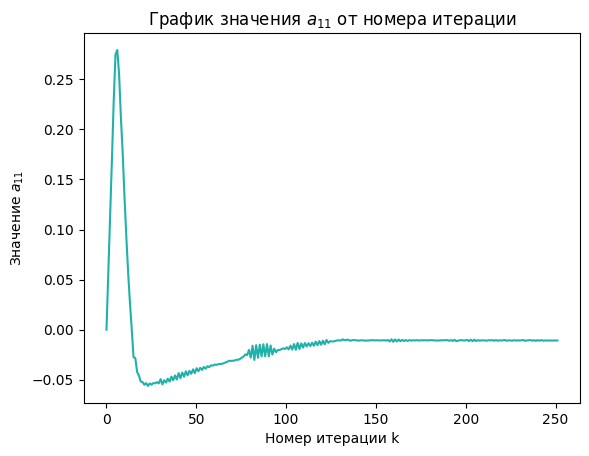

In [ ]:
num_iter=np.linspace(0,len(A), len(A))
plt.title("График значения $а_{11}$ от номера итерации") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $а_{11}$") # ось ординат
plt.plot(num_iter,a11, color='lightseagreen')

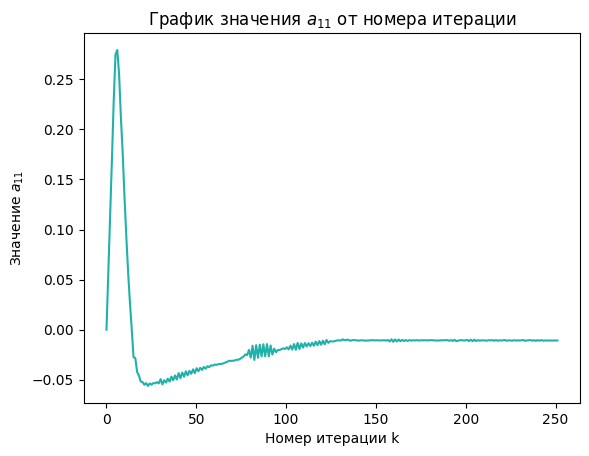

In [ ]:
num_iter=np.linspace(0,len(A), len(A))
plt.title("График значения $а_{11}$ от номера итерации") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $а_{11}$") # ось ординат
plt.plot(num_iter,a11, color='lightseagreen')

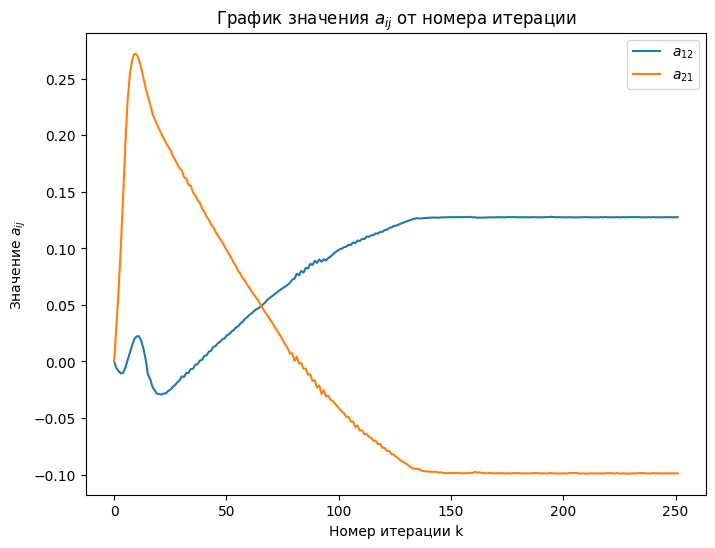

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.title(r'График значения $а_{ij}$ от номера итерации') # заголовок
ax.set_xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $а_{ij}$") # ось ординат
ax.plot(num_iter, a12, label="$а_{12}$")
ax.plot(num_iter, a21, label="$а_{21}$")
ax.legend()

plt.show()

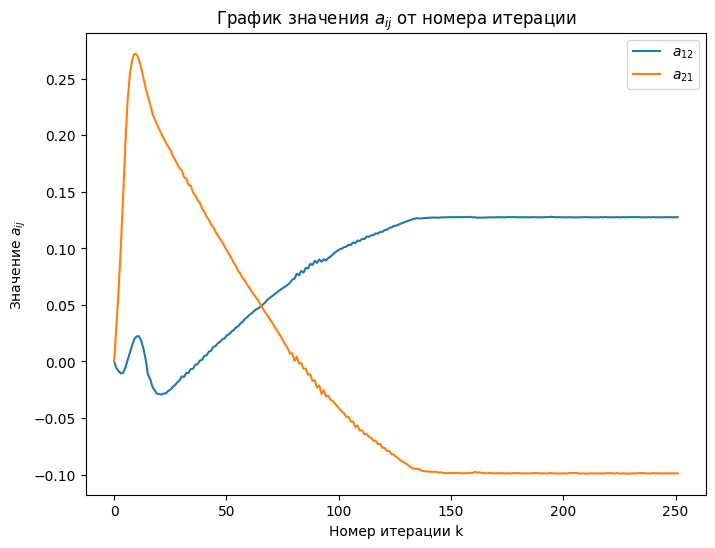

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.title(r'График значения $а_{ij}$ от номера итерации') # заголовок
ax.set_xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $а_{ij}$") # ось ординат
ax.plot(num_iter, a12, label="$а_{12}$")
ax.plot(num_iter, a21, label="$а_{21}$")
ax.legend()

plt.show()

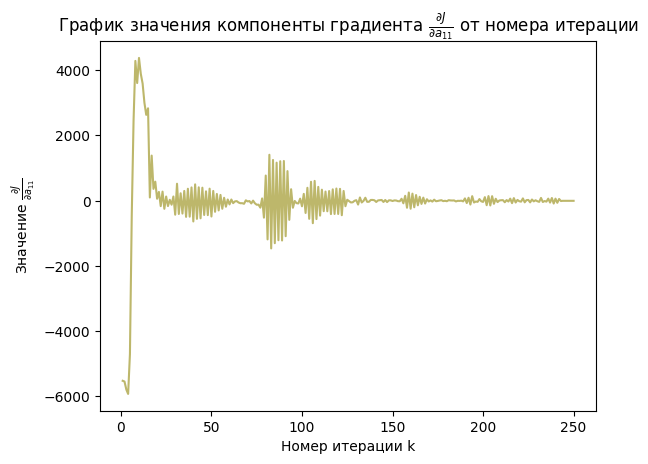

In [ ]:
num_iter=np.linspace(1,len(dJda), len(dJda))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{11}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{11}}$') # ось ординат
plt.plot(num_iter, dJda11, color='darkkhaki')

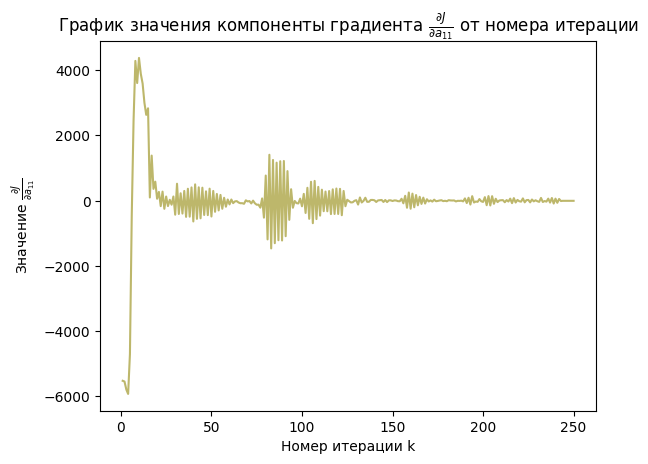

In [ ]:
num_iter=np.linspace(1,len(dJda), len(dJda))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{11}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{11}}$') # ось ординат
plt.plot(num_iter, dJda11, color='darkkhaki')

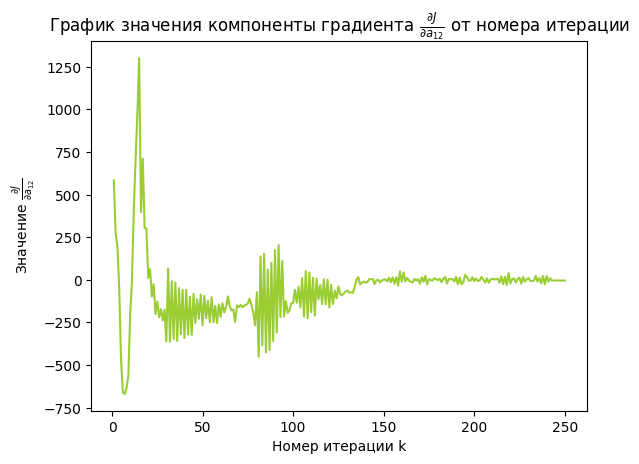

In [ ]:
num_iter=np.linspace(1,len(dJda), len(dJda))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{12}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{12}}$') # ось ординат
plt.plot(num_iter,dJda12,color='yellowgreen')

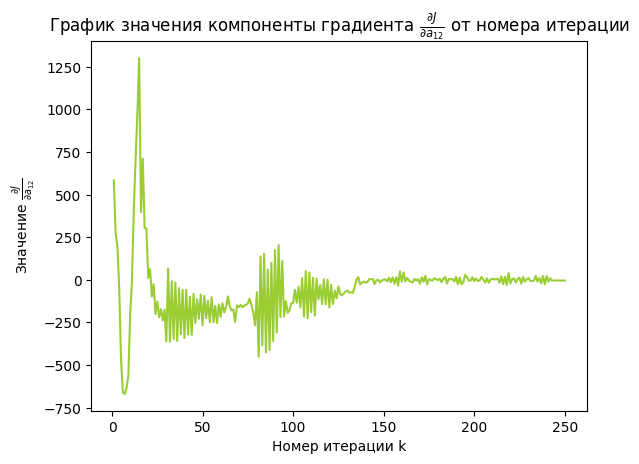

In [ ]:
num_iter=np.linspace(1,len(dJda), len(dJda))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{12}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{12}}$') # ось ординат
plt.plot(num_iter,dJda12,color='yellowgreen')

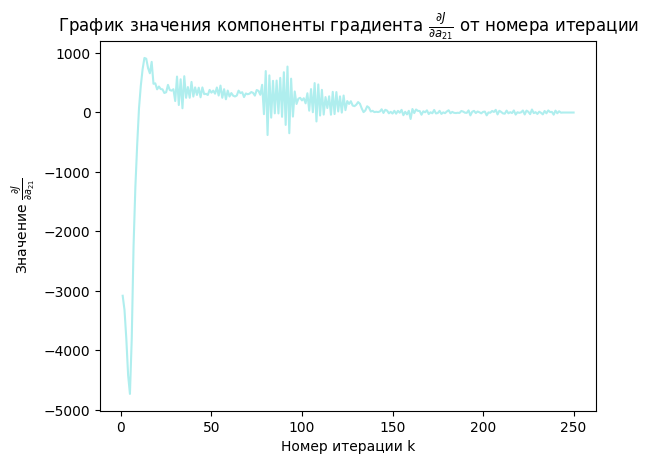

In [ ]:
num_iter=np.linspace(1,len(dJda), len(dJda))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{21}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{21}}$') # ось ординат
plt.plot(num_iter,dJda21,color='paleturquoise')

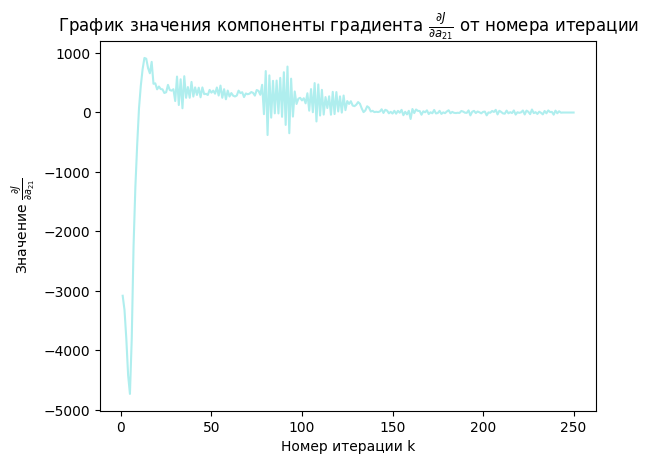

In [ ]:
num_iter=np.linspace(1,len(dJda), len(dJda))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{21}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{21}}$') # ось ординат
plt.plot(num_iter,dJda21,color='paleturquoise')

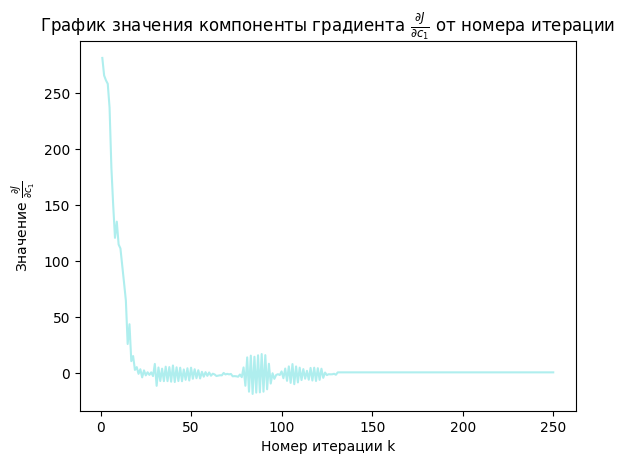

In [ ]:
num_iter=np.linspace(1,len(dJdc), len(dJdc))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial c_{1}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial c_{1}}$') # ось ординат
plt.plot(num_iter,dJdc1,color='paleturquoise')

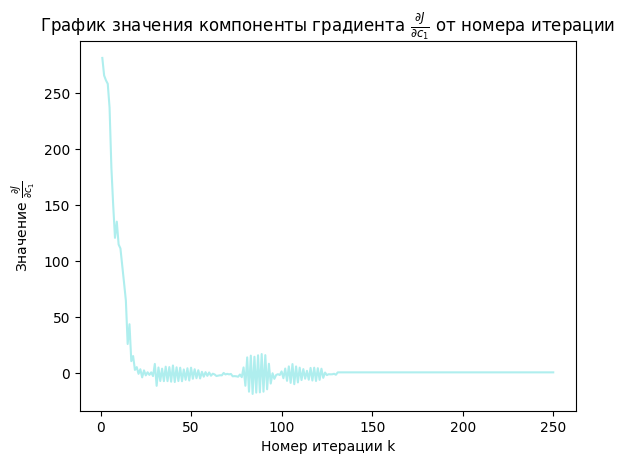

In [ ]:
num_iter=np.linspace(1,len(dJdc), len(dJdc))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial c_{1}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial c_{1}}$') # ось ординат
plt.plot(num_iter,dJdc1,color='paleturquoise')

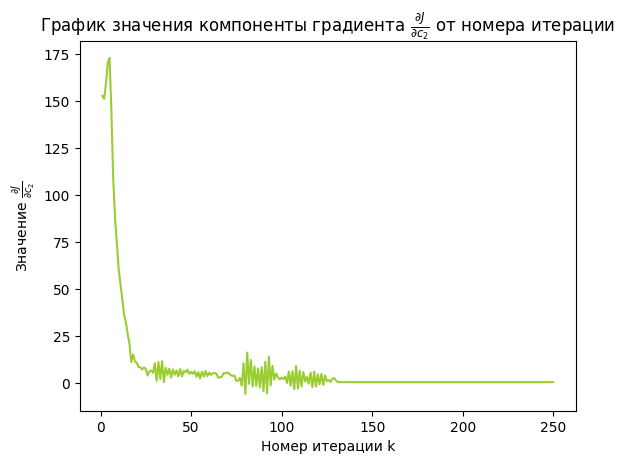

In [ ]:
num_iter=np.linspace(1,len(dJdc), len(dJdc))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial c_{2}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial c_{2}}$') # ось ординат
plt.plot(num_iter,dJdc2,color='yellowgreen')

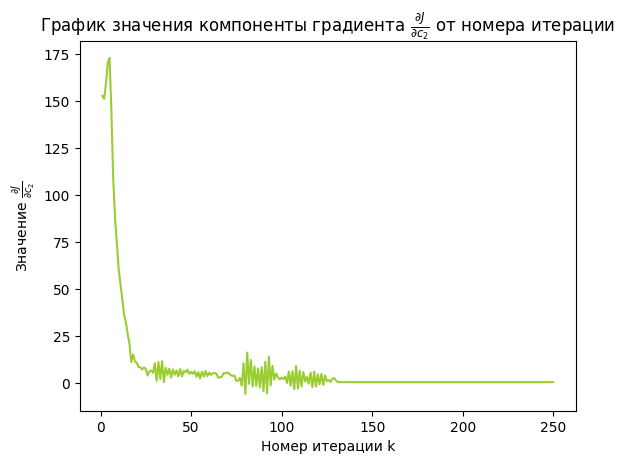

In [ ]:
num_iter=np.linspace(1,len(dJdc), len(dJdc))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial c_{2}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial c_{2}}$') # ось ординат
plt.plot(num_iter,dJdc2,color='yellowgreen')

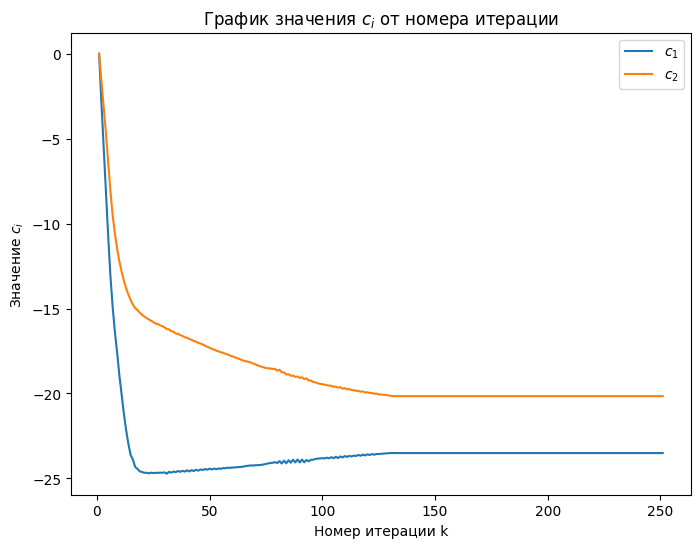

In [ ]:
num_iter=np.linspace(1,len(C), len(C))


fig, ax = plt.subplots(figsize=(8, 6))

plt.title(r'График значения $c_{i}$ от номера итерации') # заголовок
ax.set_xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $c_{i}$") # ось ординат
ax.plot(num_iter, c1, label="$c_{1}$")
ax.plot(num_iter, c2, label="$c_{2}$")
ax.legend()

plt.show()

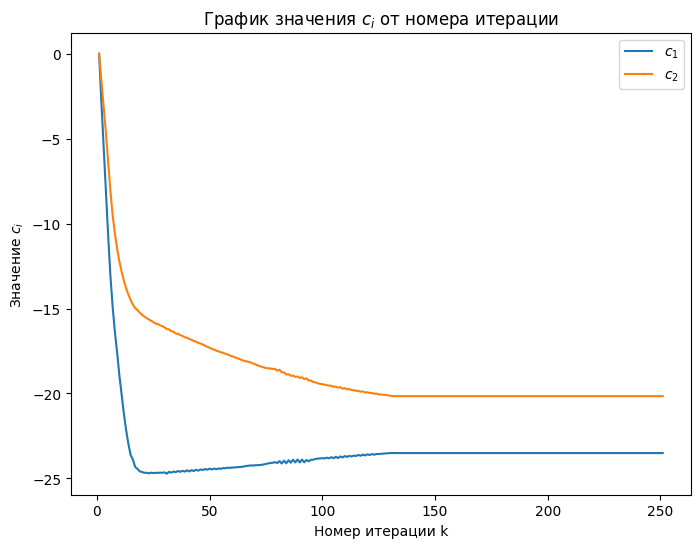

In [ ]:
num_iter=np.linspace(1,len(C), len(C))


fig, ax = plt.subplots(figsize=(8, 6))

plt.title(r'График значения $c_{i}$ от номера итерации') # заголовок
ax.set_xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $c_{i}$") # ось ординат
ax.plot(num_iter, c1, label="$c_{1}$")
ax.plot(num_iter, c2, label="$c_{2}$")
ax.legend()

plt.show()

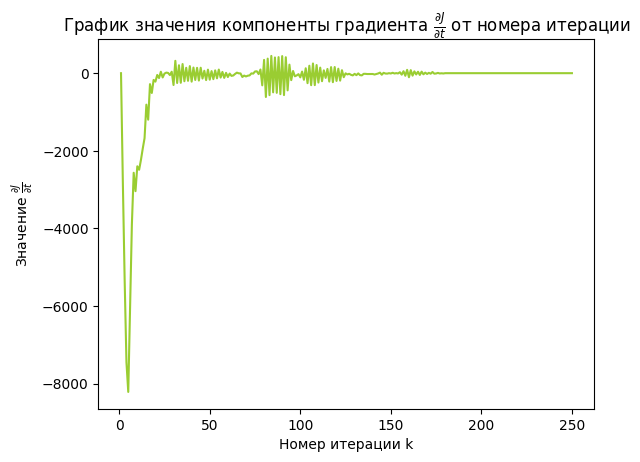

In [ ]:
num_iter=np.linspace(1,len(dJdt), len(dJdt))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial t}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial t}$') # ось ординат
plt.plot(num_iter,dJdT,color='yellowgreen')

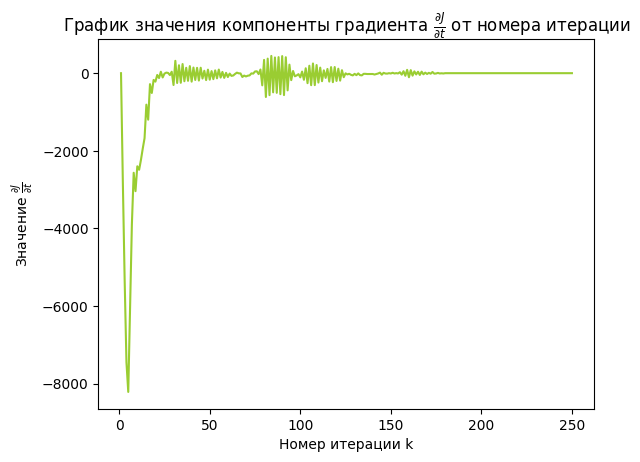

In [ ]:
num_iter=np.linspace(1,len(dJdt), len(dJdt))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial t}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial t}$') # ось ординат
plt.plot(num_iter,dJdT,color='yellowgreen')

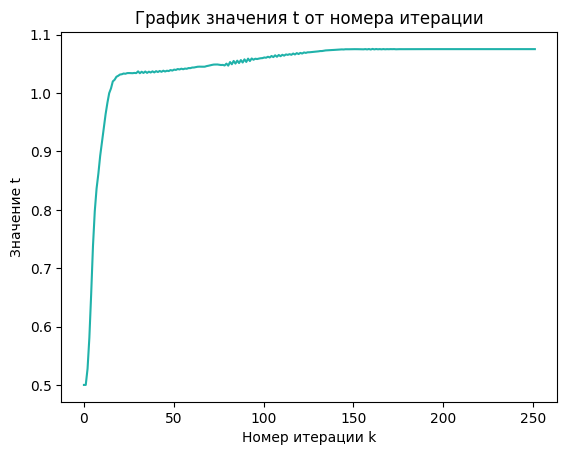

In [ ]:
num_iter=np.linspace(0,len(T), len(T))
plt.title("График значения t от номера итерации") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение t") # ось ординат
plt.plot(num_iter,t, color='lightseagreen')

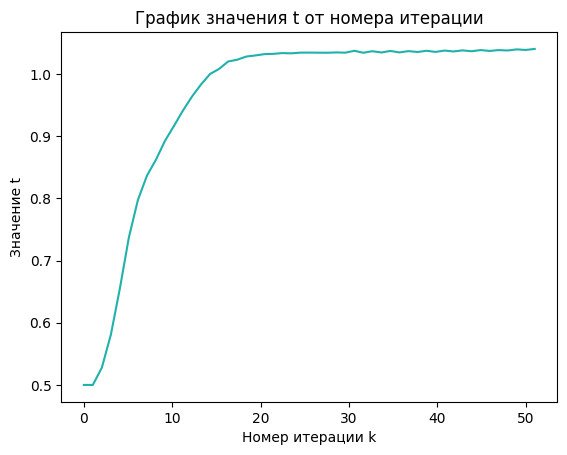

In [ ]:
num_iter=np.linspace(0,len(T), len(T))
plt.title("График значения t от номера итерации") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение t") # ось ординат
plt.plot(num_iter,t, color='lightseagreen')

In [ ]:
T

[[0.5],
 [0.5],
 [0.5277852689944278],
 [0.5808517916447723],
 [0.6553490916896334],
 [0.7375061692435056],
 [0.7974896122023796],
 [0.8364656385037398],
 [0.8621282776161088],
 [0.8925357067388661],
 [0.9165253281333579],
 [0.9414146531575829],
 [0.963776849219958],
 [0.9832166839933865],
 [0.999962062715997],
 [1.0080670502777598],
 [1.020042267319164],
 [1.0228582501147692],
 [1.0279574269083032],
 [1.0296865646663194],
 [1.0318540041512176],
 [1.0323066332147224],
 [1.0335468543346173],
 [1.03316781736639],
 [1.0342583723961893],
 [1.0343594153139462],
 [1.034207660574845],
 [1.0341321486300852],
 [1.03460739355853],
 [1.0342242811149993],
 [1.037264296536382],
 [1.0340705191804662],
 [1.0365915298501083],
 [1.0345396595618432],
 [1.0370072677780566],
 [1.0346420007640176],
 [1.0367107062905807],
 [1.0353132766921709],
 [1.0372700218236897],
 [1.035439697613774],
 [1.0376128160450753],
 [1.036155026949071],
 [1.0378962813017456],
 [1.0365104659309512],
 [1.0383956663817204],
 [1.03

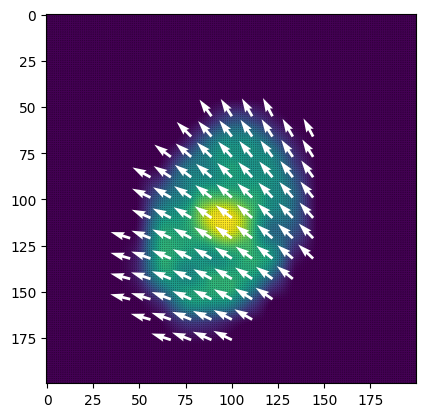

In [ ]:
#first -> second
x,y=np.meshgrid(np.linspace(0,199,199),np.linspace(0,199,199))
plt.quiver(x,y, 0.01,0.01);

for i in range(0,199,11):
    for j in range(0,199,11):
        if first[i][j]!=0.0:
            plt.quiver(j+1, i, A_curr[0][0]*j + A_curr[0][1]*i+c_curr[0]*j, - A_curr[1][0]*j + A_curr[1][1]*i-c_curr[1]*i, color=(1,1,1));




# plt.quiver(x,y, A0[0][0]*x + A0[0][1]*y + c_curr[0], A0[1][0]*x + A0[1][1]*y + c_curr[1]);
plt.imshow(first)

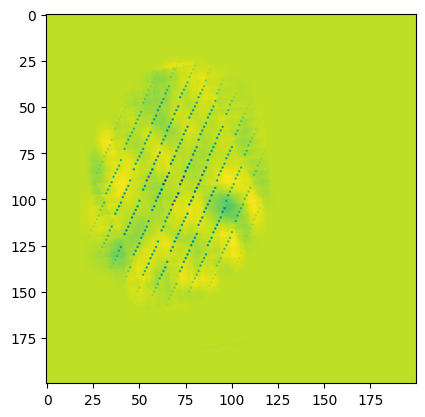

In [ ]:
plt.imshow(rho_recalculated(x_T[49][0],x_T[49][1])-second)

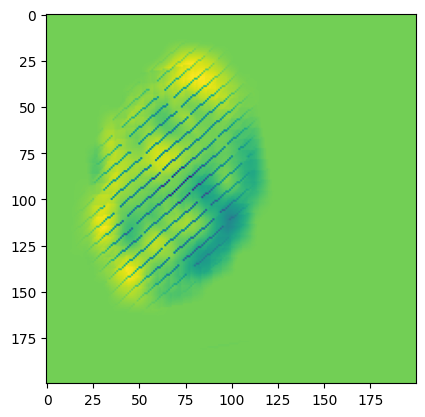

In [ ]:
plt.imshow(rho_recalculated(x_T[99][0],x_T[99][1])-second)

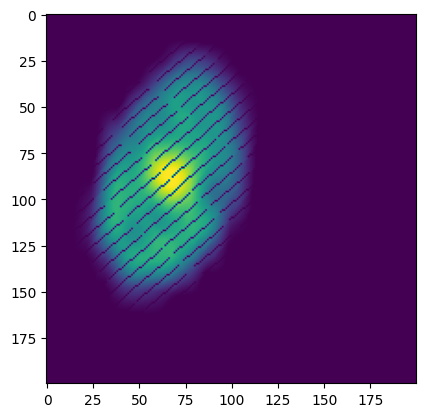

In [ ]:
plt.imshow(rho_recalculated(x_T[99][0],x_T[99][1]))

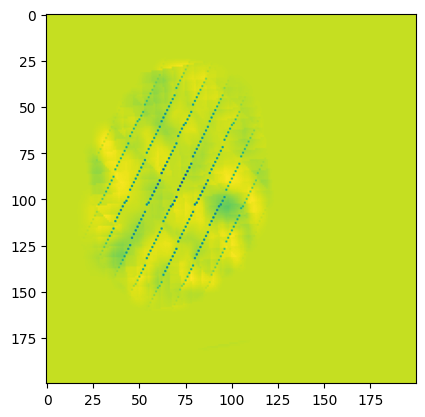

In [ ]:
plt.imshow(rho_recalculated(x_T[49][0],x_T[49][1])-second)

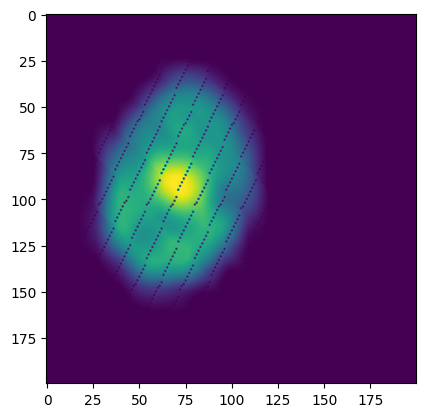

In [ ]:
plt.imshow(rho_recalculated(x_T[49][0],x_T[49][1]))

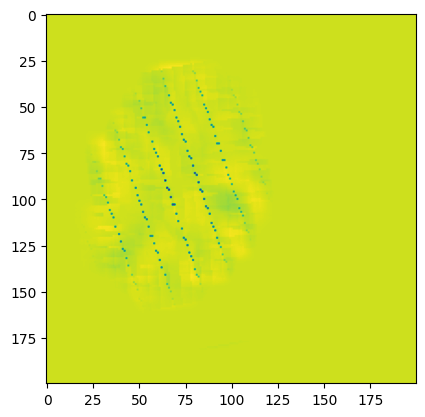

In [ ]:
plt.imshow(rho_recalculated(x_T[99][0],x_T[99][1])-second)

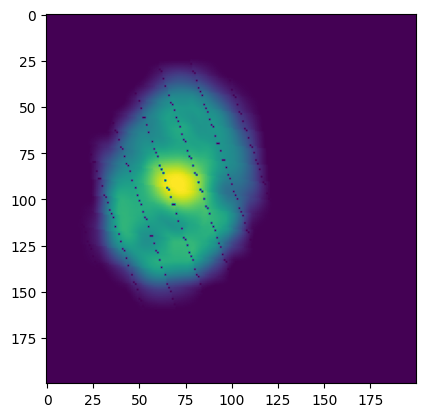

In [ ]:
plt.imshow(rho_recalculated(x_T[99][0],x_T[99][1]))

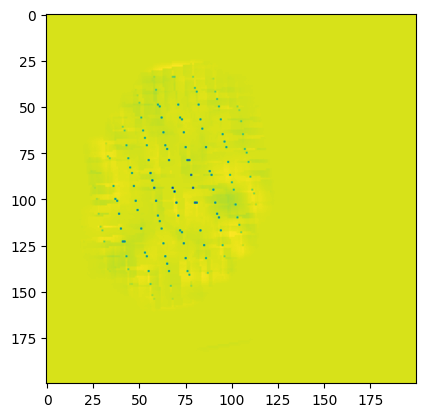

In [ ]:
plt.imshow(rho_recalculated(x_T[149][0],x_T[149][1])-second)

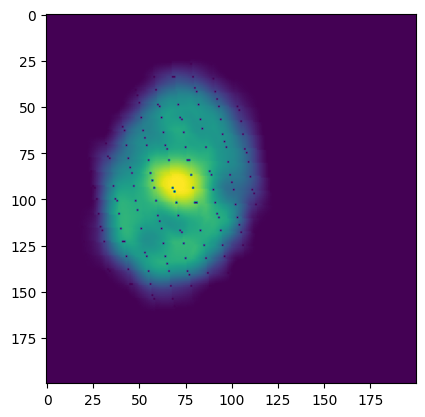

In [ ]:
plt.imshow(rho_recalculated(x_T[149][0],x_T[149][1]))

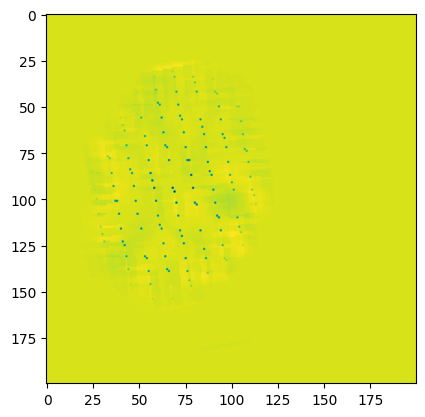

In [ ]:
plt.imshow(rho_recalculated(x_T[249][0],x_T[249][1])-second)

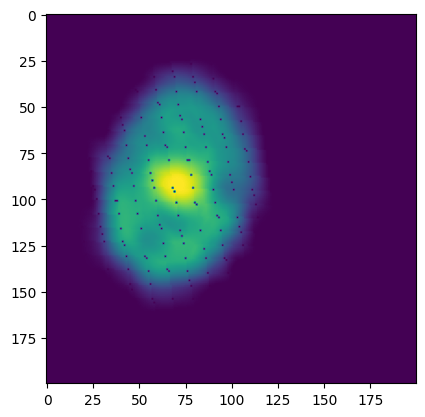

In [ ]:
plt.imshow(rho_recalculated(x_T[249][0],x_T[249][1]))

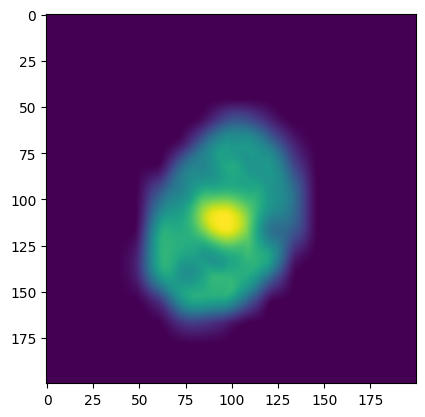

In [ ]:
plt.imshow(first)

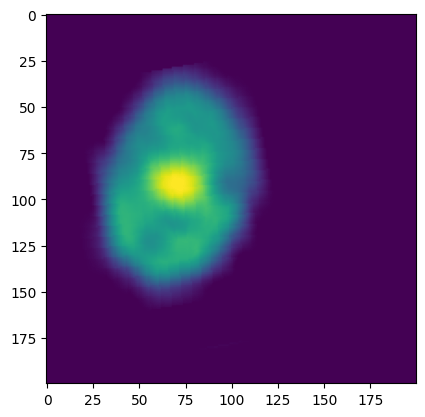

In [ ]:
plt.imshow(second)

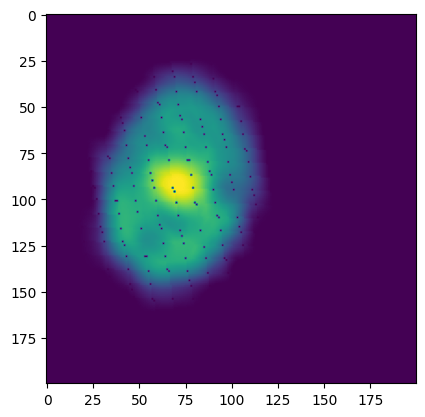

In [ ]:
plt.imshow(rho_recalculated(x_T[749][0],x_T[749][1]))

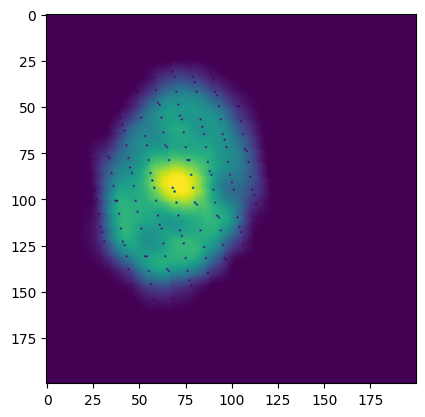

In [ ]:
plt.imshow(rho_recalculated(x_T[499][0],x_T[499][1]))

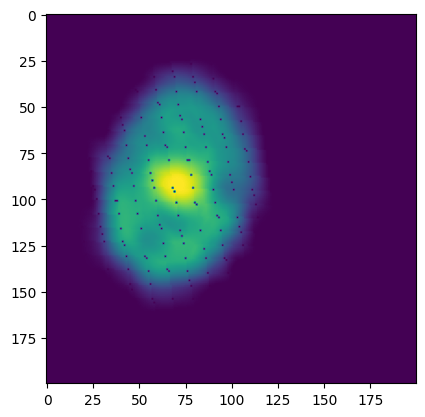

In [ ]:
plt.imshow(rho_recalculated(x_T[249][0],x_T[249][1]))

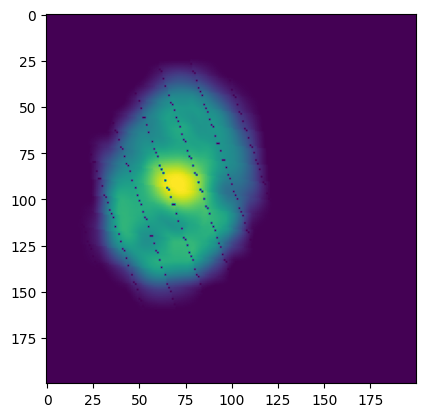

In [ ]:
plt.imshow(rho_recalculated(x_T[99][0],x_T[99][1]))

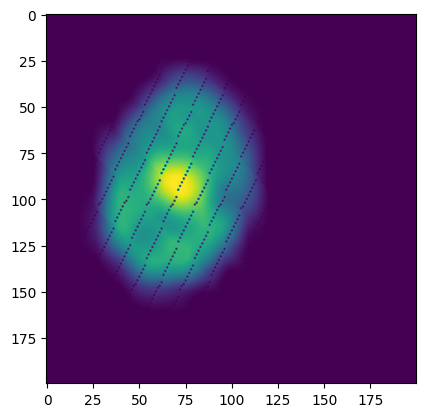

In [ ]:
plt.imshow(rho_recalculated(x_T[49][0],x_T[49][1]))

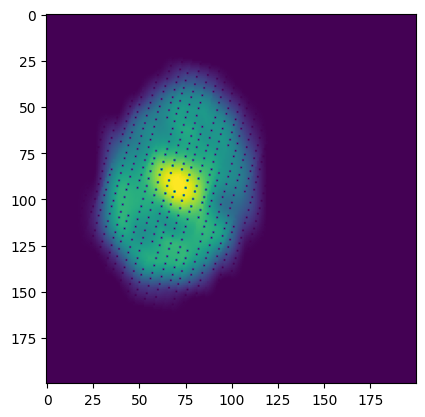

In [ ]:
plt.imshow(rho_recalculated(x_T[19][0],x_T[19][1]))

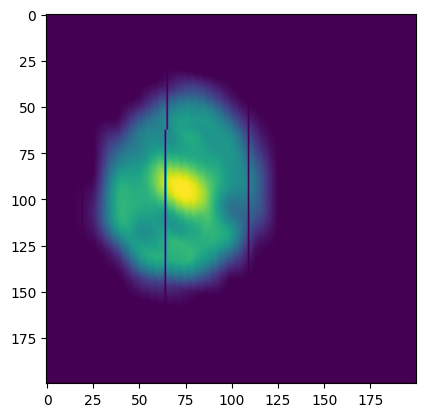

In [ ]:
plt.imshow(rho_recalculated(x_T[9][0],x_T[9][1]))

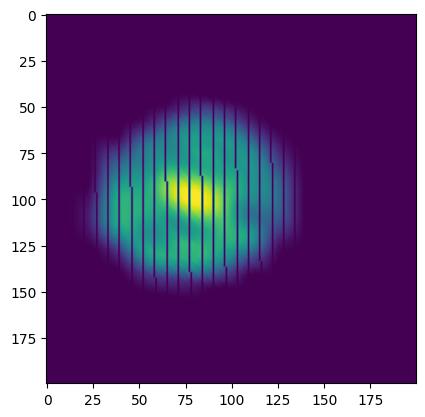

In [ ]:
plt.imshow(rho_recalculated(x_T[4][0],x_T[4][1]))

In [ ]:
plt.imshow(first)

In [ ]:
A

[[[0.0, 0.0], [0.0, 0.0]],
 [[0.11043800251185441, -0.01165898654363707],
  [0.06162073188944423, -0.11043800251185441]],
 [[0.2016348396462719, -0.01448541721407336],
  [0.13348521963165866, -0.2016348396462719]],
 [[0.20297507147746724, -0.006804973245242583],
  [0.17824433765754555, -0.20297507147746724]],
 [[0.17153381440094562, -0.0010232976955243476],
  [0.19951462625905428, -0.17153381440094562]],
 [[0.13969396567979933, 0.0028134441813734822],
  [0.2114609814433845, -0.13969396567979933]],
 [[0.1040437401121291, 0.004990443052502127],
  [0.21855399816394955, -0.1040437401121291]],
 [[0.07403900796761433, 0.005437814874699275],
  [0.22210175068924815, -0.07403900796761433]],
 [[0.04613121368263007, 0.004340333742846176],
  [0.22301650131808337, -0.04613121368263007]],
 [[0.022621139707084483, 0.00021267786835630145],
  [0.22161997808211542, -0.022621139707084483]],
 [[0.0057178689952326715, -0.004894164733247317],
  [0.21936005166203312, -0.0057178689952326715]],
 [[-0.009209739

In [ ]:
C

[[0, 0],
 [-5.630715605109145, -3.054219864154812],
 [-9.775270934055552, -6.025067910600116],
 [-12.176652265064739, -8.078128875479447],
 [-14.044867843026587, -9.491498591027602],
 [-15.959872064638501, -10.633533000658351],
 [-17.669138440908227, -11.615266367973609],
 [-19.341650122533185, -12.467850942329616],
 [-20.738844351572613, -13.204148949589783],
 [-21.9465516595796, -13.82378335598079],
 [-22.921789131607397, -14.347342984685888],
 [-23.66534277011988, -14.77177704832686],
 [-24.17101503178425, -15.139187517880359],
 [-24.5324217486464, -15.409056950841805],
 [-24.80242812729023, -15.634761321764476],
 [-24.988440558190707, -15.837027310279503],
 [-25.143226163447927, -15.976969878944075],
 [-25.247264425392608, -16.105870210113586],
 [-25.31370790681657, -16.233817703551853],
 [-25.36081987754202, -16.34459989375219],
 [-25.38384944457963, -16.43741260945588],
 [-25.40111676372063, -16.525432629274764],
 [-25.408317788726958, -16.61060379383291],
 [-25.41526450852405, -

In [ ]:
dJda

[[-11043.800251185441,
  1165.898654363707,
  -6162.073188944422,
  11043.800251185441],
 [-9119.68371344175, 282.643067043629, -7186.448774221441, 9119.68371344175],
 [-134.02318311953272,
  -768.0443968830776,
  -4475.911802588689,
  134.02318311953272],
 [3144.125707652162,
  -578.1675549718235,
  -2127.028860150872,
  -3144.125707652162],
 [3183.9848721146277,
  -383.67418768978297,
  -1194.635518433022,
  -3183.9848721146277],
 [3565.0225567670236,
  -217.69988711286447,
  -709.3016720565059,
  -3565.0225567670236],
 [3000.4732144514765,
  -44.737182219714846,
  -354.7752525298606,
  -3000.4732144514765],
 [2790.779428498425,
  109.74811318530988,
  -91.47506288352135,
  -2790.779428498425],
 [2351.0073975545583,
  412.76558744898745,
  139.65232359679544,
  -2351.0073975545583],
 [1690.327071185181,
  510.6842601603619,
  225.99264200822876,
  -1690.327071185181],
 [1492.7608521076631,
  666.234798973381,
  398.35414241092485,
  -1492.7608521076631],
 [1327.21169756769, 386.10079

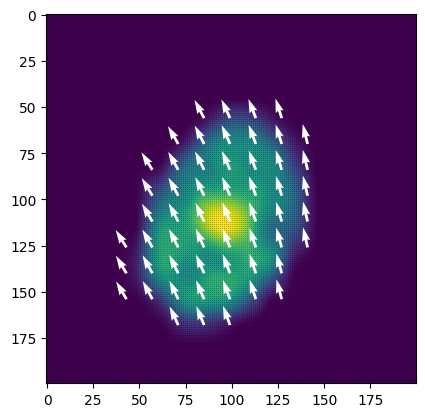

In [ ]:
k=250
#first -> second
x,y=np.meshgrid(np.linspace(0,199,190),np.linspace(0,199,190))
plt.quiver(x,y, 0.01,0.01);

for i in range(0,199,14):
    for j in range(0,199,14):
        if first[i][j]!=0.0:
            plt.quiver(j+1,i, A_curr[0][0]*i + A_curr[0][1]*j + C[k][0], - A_curr[1][0]*i + A_curr[1][1]*j -C[k][1], color=(1,1,1));





# plt.quiver(x,y, A0[0][0]*x + A0[0][1]*y + c_curr[0], A0[1][0]*x + A0[1][1]*y + c_curr[1]);
plt.imshow(first)

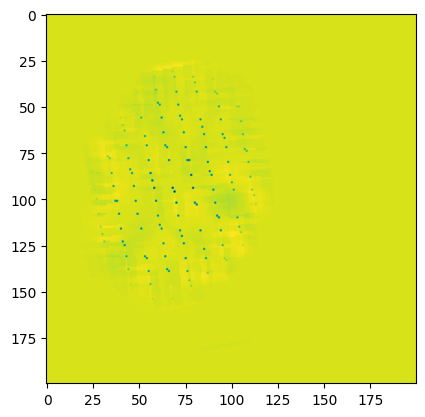

In [ ]:
plt.imshow(rho_recalculated(x_T[249][0],x_T[249][1])-second)

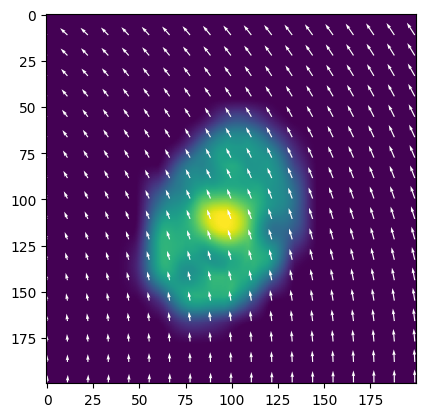

In [ ]:
x,y = np.meshgrid(np.linspace(0,199,19),np.linspace(0,199,19))
plt.quiver(x,y, A_curr[0][0]*x + A_curr[0][1]*y + c_curr[0], - A_curr[1][0]*x + A_curr[1][1]*y - c_curr[1], color=(1,1,1));
plt.imshow(first)

In [ ]:
C[k]

[-22.969949369900462, -24.69228413003546]

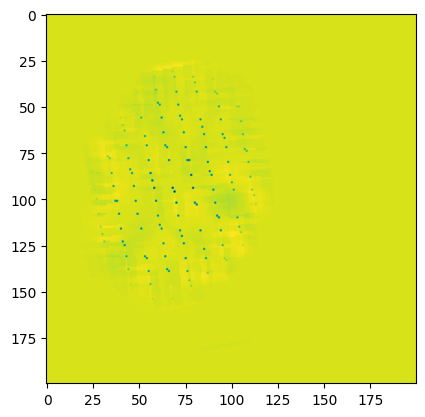

In [ ]:
plt.imshow(rho_recalculated(x_T[249][0],x_T[249][1])-second)

In [ ]:
len(x_T)

250

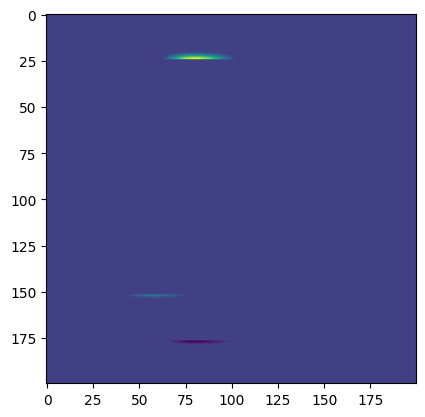

In [ ]:
plt.imshow(rho_recalculated(x_T[k][0],x_T[k][1])-second)

In [ ]:
C

[[0, 0],
 [-5.281233884403434, -3.720598846597462],
 [-10.25670786449656, -7.346832175658934],
 [-14.631703601179034, -11.042083882267502],
 [-18.144405860993636, -14.778508505275747],
 [-20.87392161988979, -18.118069768037934],
 [-22.311870101243112, -20.75267245931052],
 [-23.11503278226323, -22.38064385492759],
 [-23.319410448972615, -23.576238506557306],
 [-23.387996001537868, -23.97997570165321],
 [-23.45658155410312, -24.383712896749113],
 [-23.525167106668373, -24.787450091845017],
 [-22.969947934555083, -24.712202417873467],
 [-22.969948413003543, -24.70556298859413],
 [-22.969948891452002, -24.698923559314796],
 [-22.969949369900462, -24.69228413003546],
 [-22.96994984834892, -24.685644700756125],
 [-22.96995032679738, -24.67900527147679],
 [-22.96995080524584, -24.672365842197454],
 [-22.9699512836943, -24.66572641291812],
 [-22.96995176214276, -24.659086983638783],
 [-22.96995224059122, -24.652447554359448],
 [-22.96995271903968, -24.645808125080112],
 [-22.969953197488138, 

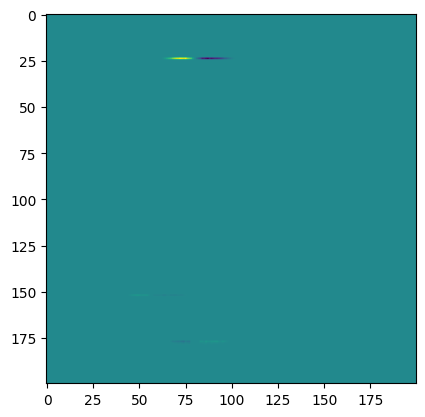

In [ ]:
plt.imshow(Psit0[29][0])